In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fsspec
import xarray as xr
import numpy as np

from vcm.catalog import catalog


timescales = [1, 3, 6, 12]
TqR_paths = [
    f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-timescale-sensitivity-tendencies-only/tau-{tau}-hr"
    for tau in timescales
]
TquvR_paths = [
    f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-timescale-sensitivity/tau-{tau}-hr"
    for tau in timescales
]


grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

with fsspec.open("gs://vcm-ml-public/argo/2021-05-04-nudge-to-c3072-prog-timescales/physics-on-baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
diags_TqR = {}
for tau, path in zip(timescales, TqR_paths):
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags_TqR[tau] = xr.open_dataset(f).load()
        
diags_TquvR = {}
for tau, path in zip(timescales, TquvR_paths):
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags_TquvR[tau] = xr.open_dataset(f).load()

In [2]:
area_land_mask = area.where(land_sea_mask==1)


verif_precip = xr.open_dataset("/home/AnnaK/explore/annak/2021-04-13-N2F-EAC-figures/40d_verif_sfc_precip.nc")
verif_precip_land_mean = (
    (verif_precip["total_precip_to_surface"] * area_land_mask).sum(skipna=True, dim=["tile", "x", "y"]) 
    / area_land_mask.sum(skipna=True)
)



<Figure size 432x288 with 0 Axes>

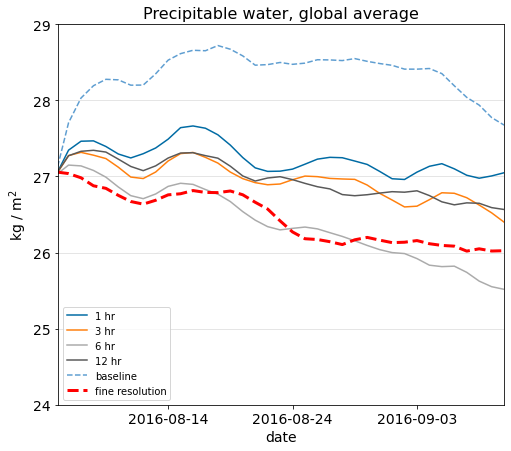

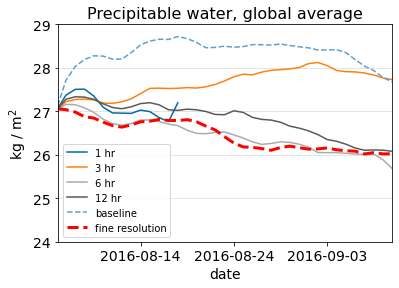

In [76]:
fig = plt.figure()

fig=plt.figure(figsize=(8,7))
for data, label in zip([diags_TqR, diags_TquvR], ["TqR-NN", "TquvR-NN"]):

    for tau, ds in data.items():
        downsample_times = [ds.time.values[0]] + [t for t in ds.time.values if t.hour==0]
        subset_times = list(set(downsample_times).intersection(list(verif_precip.time.values)))   
        ds['pwat_spatial_mean_dycore_global'].sel(time=subset_times).sortby("time").plot(label=f"{tau} hr")
    #verif_precip_land_mean.sel(time=subset_times).sortby("time").plot(linestyle="--", label="fine resolution", linewidth=3, color="red",)
    diags_baseline['pwat_spatial_mean_dycore_global'].sel(time=subset_times).sortby("time").plot(label="baseline", linestyle="--")

    verif_pw = ds['pwat_spatial_mean_dycore_global'] -  ds['pwat_mean_bias_dycore_global']
    verif_pw.sel(time=subset_times).sortby("time").plot(linestyle="--", label="fine resolution", linewidth=3, color="red",)

    plt.legend()
    plt.xlabel("date", fontsize=14)
    plt.ylabel("kg / m$^2$", fontsize=14)

    plt.xlim(min(subset_times), max(subset_times))
    plt.ylim(24, 29)

    plt.grid(True, axis="y", alpha=0.4)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.title("Precipitable water, global average", fontsize=16)
    plt.show()

/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/AnnaK/miniconda3/envs/fv3net/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

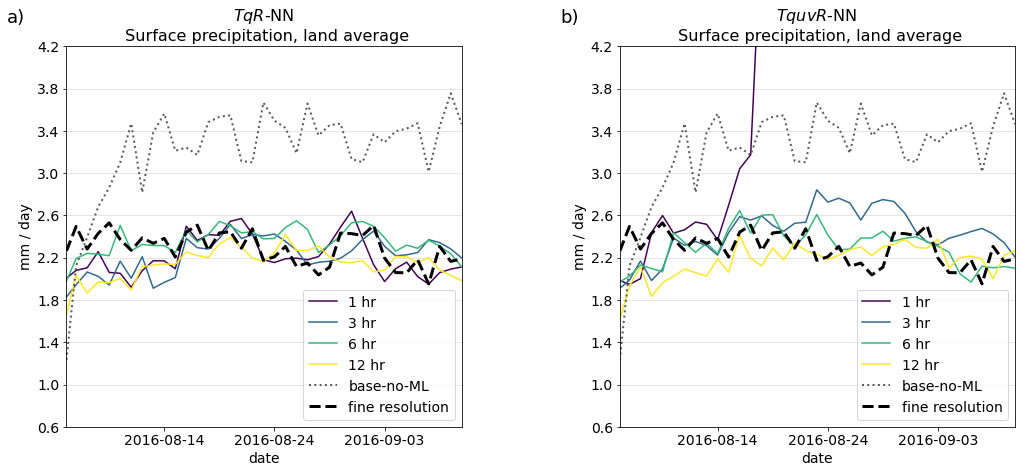

In [275]:
colors = [plt.cm.viridis(i) for i in np.linspace(0., 1., 4)]

fig = plt.figure()
fig=plt.figure(figsize=(17,7))

j=1
for data, label in zip([diags_TqR, diags_TquvR], ["$TqR$-NN", "$TquvR$-NN"]):

    ax = fig.add_subplot(1,2, j)
    for i, (tau, ds) in enumerate(data.items()):
        downsample_times = [ds.time.values[0]] + [t for t in ds.time.values if t.hour==0]
        subset_times = list(set(downsample_times).intersection(list(verif_precip.time.values)))
        ds["total_precip_to_surface_spatial_mean_physics_land"].sel(time=subset_times).sortby("time").plot(label=f"{tau} hr", color=colors[i])


    diags_baseline["total_precip_to_surface_spatial_mean_physics_land"].sel(time=subset_times).sortby("time") \
        .plot(
        label="base-no-ML", 
        linestyle=":",
        linewidth=2.,
        color='#595959',
        ax=ax
    )

    
    verif_precip_land_mean.sel(time=subset_times).sortby("time").plot(linestyle="--", label="fine resolution", linewidth=3, color="black",)

    plt.legend()
    plt.xlabel("date", fontsize=14)
    plt.ylabel("mm / day", fontsize=14)

    plt.xlim(min(subset_times), max(subset_times))
    plt.ylim(0.6, 4.2)

    plt.grid(True, axis="y", alpha=0.4)
    plt.xticks(fontsize=14)

    plt.yticks(np.linspace(0.6, 4.2, 10), fontsize=14)
    plt.title(f"{label} \n Surface precipitation, land average", fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    #plt.savefig(f"figures/nudging-timescale-sensitivity-precip-time-series-{label.replace('$', '')}.png", bbox_inches = "tight", dpi=1000)
    j+=1
plt.subplots_adjust(wspace=0.4)

ax0= fig.add_subplot(1,2,1)
ax0.text(-0.15, 1.1, "a)", va='top', fontsize=18, transform=ax0.transAxes)
ax1= fig.add_subplot(1,2,2)
ax1.text(-0.15, 1.1, "b)", va='top', fontsize=18, transform=ax1.transAxes)

plt.savefig("final/Figure_A2_nudging-timescale-sensitivity-precip.pdf", bbox_inches = "tight")


In [287]:
import pandas as pd

def plot_zonal_pressure_bias(diags, diags_baseline, var, title, ax=None, **plot_kwargs):
    if not ax is None: 
        plt.sca(ax)
    ds = xr.concat(
        [diags_baseline[[var]]] + [diags[tau][[var]] for tau in diags] ,
        dim=pd.Index(["baseline"] + [f"{tau} hr" for tau in diags.keys()], name="timescale")
    )

    fig = ds[var].plot(
        x="latitude",
        yincrease=False,
        col="timescale",
        ax=ax,
        **plot_kwargs
    )
    fig.cbar.set_label("air temperature bias [K]")
    labels = ["baseline", r"$\tau$=1 hr", r"$\tau$=3 hr", r"$\tau$=6 hr", r"$\tau$=12 hr"]
    
    for ax, label in zip(fig.axes[0], labels):
        ax.set_xlabel("latitude [deg]")
        ax.set_title(label)
    if title=="$TquvR$-NN":
        labels[1] = r"$\tau$=1 hr"+"\n(crash after 13 d)"

    plt.suptitle(title, x=0.43, y=1.07, fontsize=18)
    
    return fig


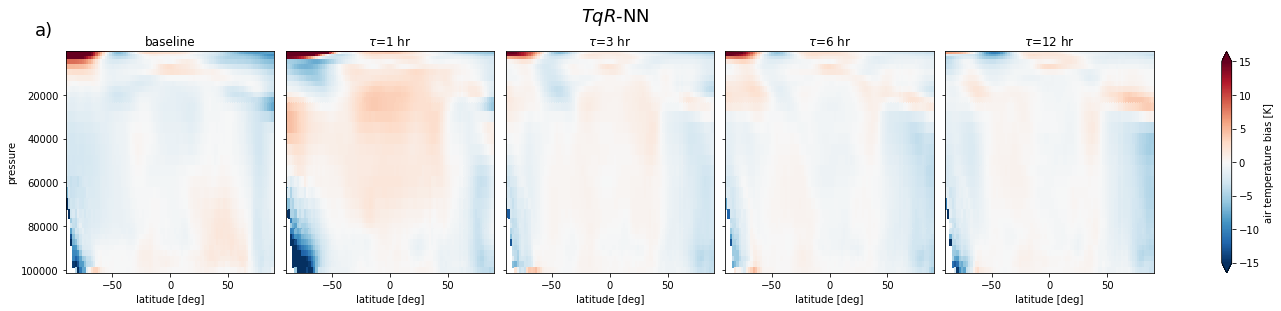

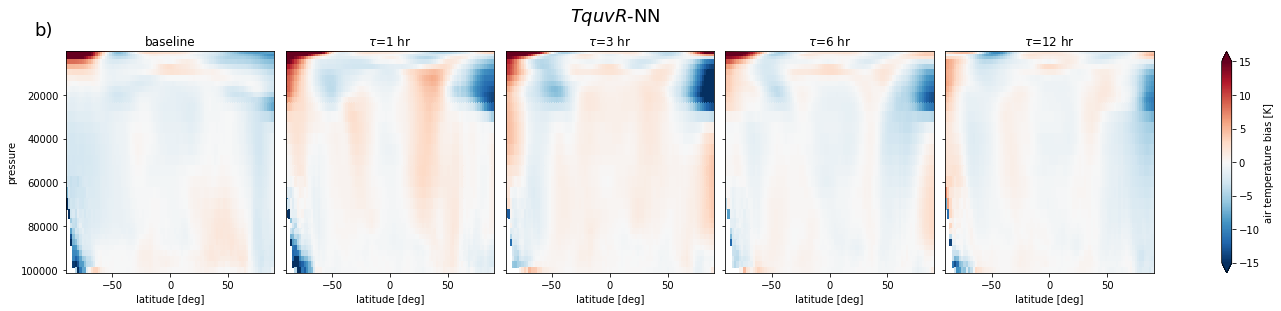

In [379]:
for data, title, subfig_letter in zip([diags_TqR, diags_TquvR], ["$TqR$-NN", "$TquvR$-NN"], ["a)", "b)"]):
    
    fig = plot_zonal_pressure_bias(data, diags_baseline, "air_temperature_pressure_level_zonal_bias", title, vmax=15, figsize=(20, 4))
    
    fig.axes[0][0].text(-0.15, 1.135, subfig_letter, va='top', fontsize=18, transform=fig.axes[0][0].transAxes)

    plt.savefig(f"final/nudging-timescale-sensitivity-Tbias-{title.replace('$', '')}.pdf", bbox_inches = "tight", dpi=200)
    plt.savefig(f"final/nudging-timescale-sensitivity-Tbias-{title.replace('$', '')}.png", bbox_inches = "tight", dpi=200)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



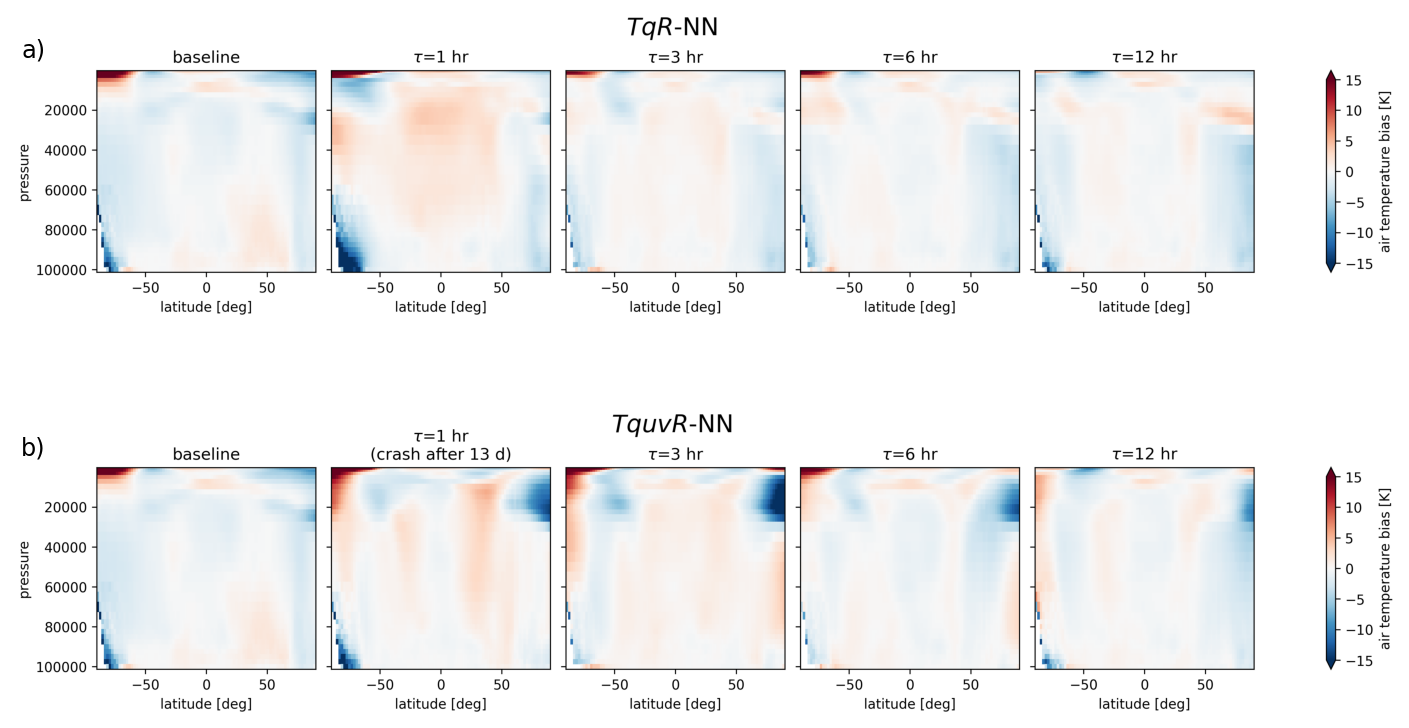

In [378]:
Tbias_TqR = mpimg.imread("figures/nudging-timescale-sensitivity-zonal-pressure-T-bias-TqR-NN.png")
Tbias_TquvR = mpimg.imread("figures/nudging-timescale-sensitivity-zonal-pressure-T-bias-TquvR-NN.png")


fig = plt.figure(figsize=(25,15))

ax2= fig.add_subplot(2,1,1)
ax2.imshow(Tbias_TqR)
ax2.text(0.01, 0.9, "a)", va='top', fontsize=24, transform=ax2.transAxes)
plt.axis('off')

ax3= fig.add_subplot(2,1,2)
ax3.imshow(Tbias_TquvR)
ax3.text(0.01, 0.9, "b)", va='top', fontsize=24, transform=ax3.transAxes)
plt.axis('off')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.1, hspace=-0.05)
plt.savefig("final/Figure_A3_nudging-timescale-sensitivity-Tbias.png", bbox_inches = "tight")
